# 0. Library Import

In [96]:
# 기본 라이브러리
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 전처리
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 모델링
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dropout

# 사전학습모델
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3

# 모델 평가
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 하이퍼파라미터 튜닝

# tensorflow 버전 확인
tf.__version__

'2.12.0'

In [2]:
random.seed(1)
np.random.seed(1)
os.environ["PYTHONHASHSEED"] = str(1)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)
tf.random.set_seed(1)

In [3]:
# 소수점 4자리까지 보이도록 설정
pd.set_option('display.float_format', '{:,.4f}'.format)

# 1. Preprocessing

## 1.1 Data Split (Train / Val / Test)

In [4]:
# splitfolders.ratio('data/train', output='data_splited', seed=42, ratio=(.8, .1, .1))

## 1.2 Preprocessing using Image Generator

In [104]:
# training set preprocessing

training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)

train_dataset = training_generator.flow_from_directory('data_splited/train',
                                                        target_size = (64, 64),
                                                        batch_size = 8,
                                                        class_mode = 'sparse',
                                                        shuffle = True)

Found 2759 images belonging to 19 classes.


In [105]:
# val set preprocessing

val_generator = ImageDataGenerator(rescale=1./255)
val_dataset = val_generator.flow_from_directory('data_splited/val',
                                                target_size = (64, 64),
                                                batch_size = 8,
                                                class_mode = 'sparse',
                                                shuffle = True)

Found 338 images belonging to 19 classes.


In [106]:
# test set preprocessing

test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('data_splited/test',
                                                     target_size = (64, 64),
                                                     batch_size = 8,
                                                     class_mode = 'sparse',
                                                     shuffle = True)

Found 360 images belonging to 19 classes.


## Target Class 확인

In [8]:
train_dataset.class_indices

{'가구수정': 0,
 '걸레받이수정': 1,
 '곰팡이': 2,
 '꼬임': 3,
 '녹오염': 4,
 '들뜸': 5,
 '면불량': 6,
 '몰딩수정': 7,
 '반점': 8,
 '석고수정': 9,
 '오염': 10,
 '오타공': 11,
 '울음': 12,
 '이음부불량': 13,
 '창틀,문틀수정': 14,
 '터짐': 15,
 '틈새과다': 16,
 '피스': 17,
 '훼손': 18}

In [9]:
# 총 19개 class로 나뉘어 있으며 class마다 데이터 갯수가 달라 불균형하다

unique, counts = np.unique(train_dataset.classes, return_counts = True)
uniq_dict = dict(zip(unique, counts))
uniq_dict

{0: 9,
 1: 245,
 2: 116,
 3: 168,
 4: 11,
 5: 43,
 6: 79,
 7: 104,
 8: 2,
 9: 45,
 10: 476,
 11: 113,
 12: 17,
 13: 13,
 14: 21,
 15: 129,
 16: 4,
 17: 40,
 18: 1124}

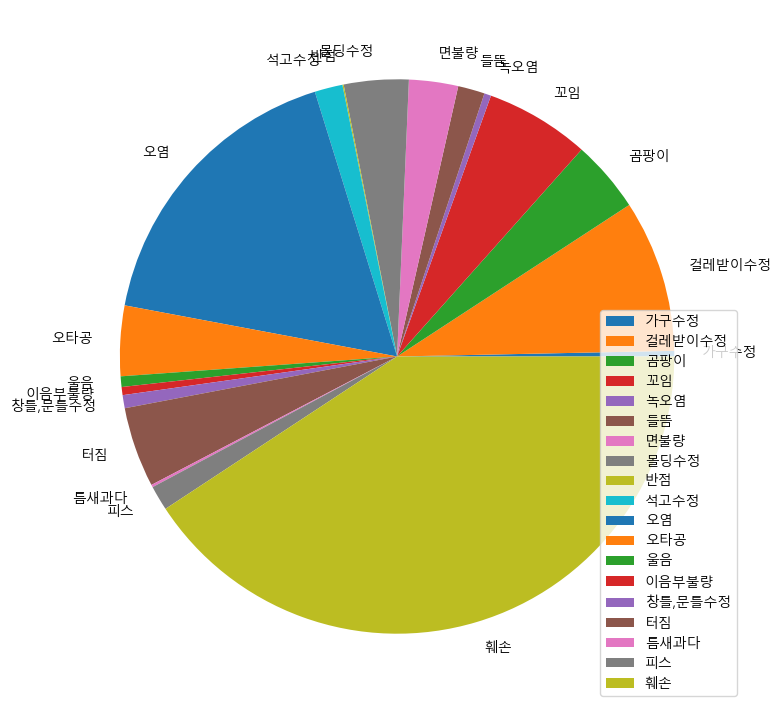

In [10]:
# ****************차트 더 다듬어야  : 가로 또는 세로로 막대 그래프로 나타내기

# target class 비율 시각화
# label마다 하자 유형 이름 넣고 파이 차트 키우기

# # 한글 폰트 사용을 위해서 세팅
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

labels = train_dataset.class_indices.keys()
sizes = np.unique(train_dataset.classes, return_counts = True)[1]

plt.figure(figsize=(9, 9))
plt.pie(sizes, labels=labels)
plt.legend(labels)

# 2. 모델 선정

## 2.1 Basic CNN

In [11]:
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), input_shape = (64,64,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(units = 3137, activation='relu'))
cnn.add(Dense(units = 3137, activation='relu'))
cnn.add(Dense(units = 19, activation='softmax'))


In [12]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [14]:
checkpoint_filepath = "CNNbest.hdf5"

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# best model 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

results = cnn.fit(x = train_dataset, validation_data = val_dataset, 
                  batch_size=8, epochs=100, verbose=1,
                  callbacks = [early_stop, save_best])


# 1 epoch 당 70초 걸림

Epoch 1/100
345/345 [==============================] - ETA: 0s - loss: 2.0958 - accuracy: 0.4063 - f1_m: 10.8390
Epoch 1: val_loss improved from inf to 2.00679, saving model to FMbest.hdf5
345/345 [==============================] - 70s 198ms/step - loss: 2.0958 - accuracy: 0.4063 - f1_m: 10.8390 - val_loss: 2.0068 - val_accuracy: 0.4142 - val_f1_m: 10.3779
Epoch 2/100
345/345 [==============================] - ETA: 0s - loss: 2.0530 - accuracy: 0.4074 - f1_m: 10.6213
Epoch 2: val_loss did not improve from 2.00679
345/345 [==============================] - 67s 194ms/step - loss: 2.0530 - accuracy: 0.4074 - f1_m: 10.6213 - val_loss: 2.0417 - val_accuracy: 0.4142 - val_f1_m: 4.1720
Epoch 3/100
345/345 [==============================] - ETA: 0s - loss: 2.0507 - accuracy: 0.4081 - f1_m: 10.3877
Epoch 3: val_loss improved from 2.00679 to 1.99079, saving model to FMbest.hdf5
345/345 [==============================] - 69s 201ms/step - loss: 2.0507 - accuracy: 0.4081 - f1_m: 10.3877 - val_loss:

Epoch 24: early stopping


In [107]:
eval_table = pd.DataFrame(index=['Loss', 'Accuracy', 'F1_score'], 
                          columns=['Custom CNN', 'ResNet', 'EfficientNet'])

# evaluate the model
def model_score(model, val_dataset, column):
    val_predict = model.predict(val_dataset)
    val_predict = np.argmax(val_predict, axis = 1)
    
    # classificaton_report
    print(classification_report(val_dataset.classes, val_predict))
    
    loss = round(model.evaluate(val_dataset, verbose=0)[0], ndigits=3)
    accuracy = round(accuracy_score(val_dataset.classes, val_predict), ndigits=3)
    f1 = round(f1_score(val_dataset.classes, val_predict, average='micro'), ndigits=3)
    
    eval_table[column] = [loss, accuracy, f1]

    return eval_table

In [108]:
model_score(cnn, val_dataset, 'Custom CNN')

43/43 [==============================] - 3s 75ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        14
           3       0.04      0.05      0.04        21
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         5
          10       0.13      0.03      0.05        59
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        16
          17       0.00      0.00      0.00         5
          18       0.43    

C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Custom CNN,ResNet,EfficientNet
Loss,1.5770,NaN,NaN
Accuracy,0.2630,NaN,NaN
F1_score,0.2630,NaN,NaN


## 2.2 ResNet50V2

In [109]:
# 해당 사전모델의 올바른 input_shape은 224*224로 전처리를 다시 해야한다

# training set preprocessing

training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)

train_dataset = training_generator.flow_from_directory('data_splited/train',
                                                        target_size = (224, 224),
                                                        batch_size = 32,
                                                        class_mode = 'sparse',
                                                        shuffle = True)


# val set preprocessing

val_generator = ImageDataGenerator(rescale=1./255)
val_dataset = val_generator.flow_from_directory('data_splited/val',
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = 'sparse',
                                                shuffle = True)

# test set preprocessing

test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('data_splited/test',
                                                     target_size = (224, 224),
                                                     batch_size = 32,
                                                     class_mode = 'sparse',
                                                     shuffle = True)

Found 2759 images belonging to 19 classes.
Found 338 images belonging to 19 classes.
Found 360 images belonging to 19 classes.


In [82]:
# ResNet50 모델 불러오기
# include_top=False : 사전학습된 가중치를 사용하되 마지막엔 coustom dense layer를 만들기 위해 설정
resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [83]:
# Freezing resnet layers
for layer in resnet.layers:
  layer.trainable = False

In [84]:
# resnet 모델의 끝부분에 추가할 custom layer 작성 
custom_layer = resnet.output 
custom_layer = GlobalAveragePooling2D()(custom_layer) # 가장 마지막층의 shape인 행렬을 벡터화
custom_layer = Dense(units = 1025, activation='relu')(custom_layer)
custom_layer = Dropout(rate = 0.2)(custom_layer)
custom_layer = Dense(units = 1025, activation='relu')(custom_layer)
custom_layer = Dropout(rate = 0.2)(custom_layer)
custom_layer = Dense(19, activation='softmax')(custom_layer)

In [85]:
# resnet 모델에 custom layer 연결
resnet_customed = Model(inputs = resnet.input, outputs = custom_layer)

In [86]:
resnet_customed.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalizat

In [87]:
resnet_customed.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [88]:
checkpoint_filepath = "ResNetbest.hdf5"

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# best model 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

results = resnet_customed.fit(x = train_dataset, validation_data = val_dataset, 
                  batch_size=32, epochs=100, verbose=1,
                  callbacks = [early_stop, save_best])


# 1 epoch 당 2분 걸림

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.4162 - accuracy: 0.5538
Epoch 1: val_loss improved from inf to 1.14626, saving model to FMbest.hdf5
87/87 [==============================] - 140s 2s/step - loss: 1.4162 - accuracy: 0.5538 - val_loss: 1.1463 - val_accuracy: 0.5947
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 1.0080 - accuracy: 0.6636
Epoch 2: val_loss improved from 1.14626 to 1.01441, saving model to FMbest.hdf5
87/87 [==============================] - 133s 2s/step - loss: 1.0080 - accuracy: 0.6636 - val_loss: 1.0144 - val_accuracy: 0.6450
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.7195
Epoch 3: val_loss did not improve from 1.01441
87/87 [==============================] - 132s 2s/step - loss: 0.8369 - accuracy: 0.7195 - val_loss: 1.0694 - val_accuracy: 0.6302
Epoch 4/100
87/87 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7463
Epoch 4: val_loss did not i

In [110]:
# classificaton_report

val_predict = resnet_customed.predict(val_dataset)
val_predict = np.argmax(val_predict, axis = 1)

print(classification_report(val_dataset.classes, val_predict))

11/11 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.12      0.13      0.13        30
           2       0.25      0.29      0.27        14
           3       0.04      0.05      0.05        21
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         5
          10       0.16      0.14      0.15        59
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        16
          17       0.00      0.00      0.00         5
          18       0.40     

C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
model_score(resnet_customed, val_dataset, 'ResNet')

11/11 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.12      0.13      0.13        30
           2       0.00      0.00      0.00        14
           3       0.13      0.14      0.14        21
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         5
           6       0.10      0.11      0.11         9
           7       0.13      0.15      0.14        13
           9       0.25      0.20      0.22         5
          10       0.14      0.12      0.13        59
          11       0.07      0.07      0.07        14
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.08      0.06      0.07        16
          17       0.00      0.00      0.00         5
          18       0.36     

C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\octob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


         Custom CNN  ResNet EfficientNet
Loss            NaN  1.2800          NaN
Accuracy        NaN  0.2130          NaN
F1_score        NaN  0.2130          NaN


## EfficientNetV2B3

In [89]:
# EfficientNetV2 모델 불러오기
effnetv2_model = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

# 모델 구성하기
effnet = Sequential() 
effnet.add(effnetv2_model)
effnet.add(Dense(256, activation='relu'))  # 첫 번째 은닉층
effnet.add(Dense(128, activation='relu'))  # 두 번째 은닉층
effnet.add(Dense(19, activation='softmax'))

# 모델 컴파일하기
effnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

28456008/28456008 [==============================] - 3s 0us/step


In [90]:
cnn.fit(x = train, validation_data = val, epochs = 10)

Epoch 1/10
87/87 [==============================] - 46s 529ms/step - loss: 1.8541 - accuracy: 0.4224 - val_loss: 1.8317 - val_accuracy: 0.4336
Epoch 2/10
87/87 [==============================] - 47s 542ms/step - loss: 1.8126 - accuracy: 0.4329 - val_loss: 1.8083 - val_accuracy: 0.4453
Epoch 3/10
87/87 [==============================] - 47s 546ms/step - loss: 1.8111 - accuracy: 0.4398 - val_loss: 1.8421 - val_accuracy: 0.4204
Epoch 4/10
87/87 [==============================] - 47s 546ms/step - loss: 1.7890 - accuracy: 0.4351 - val_loss: 1.8227 - val_accuracy: 0.4277
Epoch 5/10
87/87 [==============================] - 45s 522ms/step - loss: 1.7858 - accuracy: 0.4387 - val_loss: 1.7604 - val_accuracy: 0.4453
Epoch 6/10
87/87 [==============================] - 45s 521ms/step - loss: 1.7575 - accuracy: 0.4481 - val_loss: 1.8588 - val_accuracy: 0.4263
Epoch 7/10
87/87 [==============================] - 44s 511ms/step - loss: 1.7905 - accuracy: 0.4351 - val_loss: 1.7256 - val_accuracy: 0.4540